# TIM - The Ineference Machine

## This is the first tutorial for TIM, the code-formally-known as PEYOte.
May PEYOte rest in peace

TIM is a fast, easy to use parameter estimation code for gravitational-wave astronomy.  This tutorial will take you through the basics steps of creating a model waveform, injecting that waveform into simulated noise, and then recovering that signal.

In [1]:
%pylab inline
# %matplotlib notebook
import numpy as np
import pylab as plt

%load_ext autoreload
%autoreload 2
import peyote
from dynesty import plotting as dyplot

Populating the interactive namespace from numpy and matplotlib


## Define a source and simulate data

2048.0 1.0 1.0


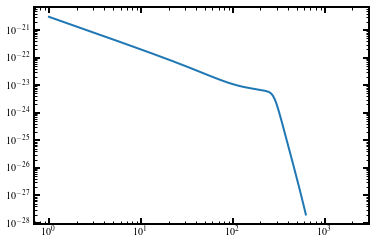

In [2]:
time_duration = 1.
sampling_frequency = 4096.

bbh_simulation_parameters = dict(
mass_1 = 36.,
mass_2 = 29.,
spin_1 = [0, 0, 0], 
spin_2 = [0, 0, 0],
luminosity_distance = 410.,
inclination_angle = 0., 
waveform_phase = 0., 
waveform_approximant = 'IMRPhenomPv2',
reference_frequency = 50.,
)

source = peyote.source.BinaryBlackHole('BBH', sampling_frequency, time_duration)
hf_signal = source.frequency_domain_strain(bbh_simulation_parameters)

plt.loglog(source.frequency_array, np.abs(hf_signal['plus']))

In [2]:
# Properties of the data
time_duration = 1.
sampling_frequency = 4096.

# Simulated source properties
simulation_parameters = dict(
    A=1e-21, 
    f=100,
    geocent_time=0,
    ra=1, 
    dec=2, 
    psi=0)

# Make a source instance and get the frequency domain realisation
source = peyote.source.SimpleSinusoidSource(
    'sin', sampling_frequency, time_duration)
hf_signal = source.frequency_domain_strain(simulation_parameters)

# Simulate the data in H1
IFO = peyote.detector.H1
hf_noise, frequencies = IFO.power_spectral_density.get_noise_realisation(
    sampling_frequency, time_duration)
IFO.set_data(frequency_domain_strain=hf_noise)
IFO.inject_signal(source, simulation_parameters)
IFO.set_spectral_densities(frequencies)
IFO.whiten_data()

# Plot the noise and signal
plt.loglog(frequencies, np.abs(hf_noise), lw=1.5, label='noise+signal')
plt.loglog(frequencies, np.abs(hf_signal['plus']), lw=0.8, label='signal')
plt.xlim(10, 1000)
plt.legend()
plt.xlabel(r'frequency')
plt.ylabel(r'strain')
plt.show()

<IPython.core.display.Javascript object>

{'cross': array([ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]),
 'plus': array([-0.-0.j, -0.-0.j, -0.-0.j, ..., -0.-0.j, -0.-0.j, -0.-0.j])}

## Search the data

In [3]:
likelihood = peyote.likelihood.likelihood([IFO], source)

prior = simulation_parameters
prior['f'] = peyote.parameter.Parameter(
    'f', prior=peyote.prior.Uniform(lower=95, upper=105))
prior['A'] = peyote.parameter.Parameter(
    'A', prior=peyote.prior.Uniform(lower=0, upper=1e-19))


res = peyote.run_sampler(likelihood, prior, 'nestle', npoints=100)
fig, axes = dyplot.traceplot(res)
fig.tight_layout()
fig.show()

Search parameters = ['A', 'f']


<IPython.core.display.Javascript object>